No dtype selected, switching to float64 to match model dtype.
Running Molecular Dynamics Simulation...
Time: 0.00 fs, Energy: -53329.458 eV, Temperature: 0.00 K


/tmp/ipykernel_618761/363376477.py:25: FutureWarning: Please use atoms.calc = calc
  init_conf.set_calculator(calculator)  # 设置计算器（此处calculator为MACE）


Time: 20.00 fs, Energy: -53331.720 eV, Temperature: 171.50 K
Time: 40.00 fs, Energy: -53332.271 eV, Temperature: 217.06 K
Time: 60.00 fs, Energy: -53332.548 eV, Temperature: 242.42 K
Time: 80.00 fs, Energy: -53332.887 eV, Temperature: 272.08 K
Time: 100.00 fs, Energy: -53332.532 eV, Temperature: 243.75 K
Time: 120.00 fs, Energy: -53332.526 eV, Temperature: 253.43 K
Time: 140.00 fs, Energy: -53332.507 eV, Temperature: 248.72 K
Time: 160.00 fs, Energy: -53332.856 eV, Temperature: 273.32 K
Time: 180.00 fs, Energy: -53332.731 eV, Temperature: 266.30 K
Time: 200.00 fs, Energy: -53332.572 eV, Temperature: 261.74 K
Time: 220.00 fs, Energy: -53332.120 eV, Temperature: 228.33 K
Time: 240.00 fs, Energy: -53332.431 eV, Temperature: 254.56 K
Time: 260.00 fs, Energy: -53332.588 eV, Temperature: 267.97 K
Time: 280.00 fs, Energy: -53332.389 eV, Temperature: 261.17 K
Time: 300.00 fs, Energy: -53332.394 eV, Temperature: 259.74 K
Time: 320.00 fs, Energy: -53332.456 eV, Temperature: 262.31 K
Time: 340.00

Time: 2000.00 fs, Energy: -53331.684 eV, Temperature: 294.28 K
Simulation completed. Results saved in test.xyz.
No dtype selected, switching to float64 to match model dtype.


100%|██████████| 630/630 [00:18<00:00, 33.73it/s]


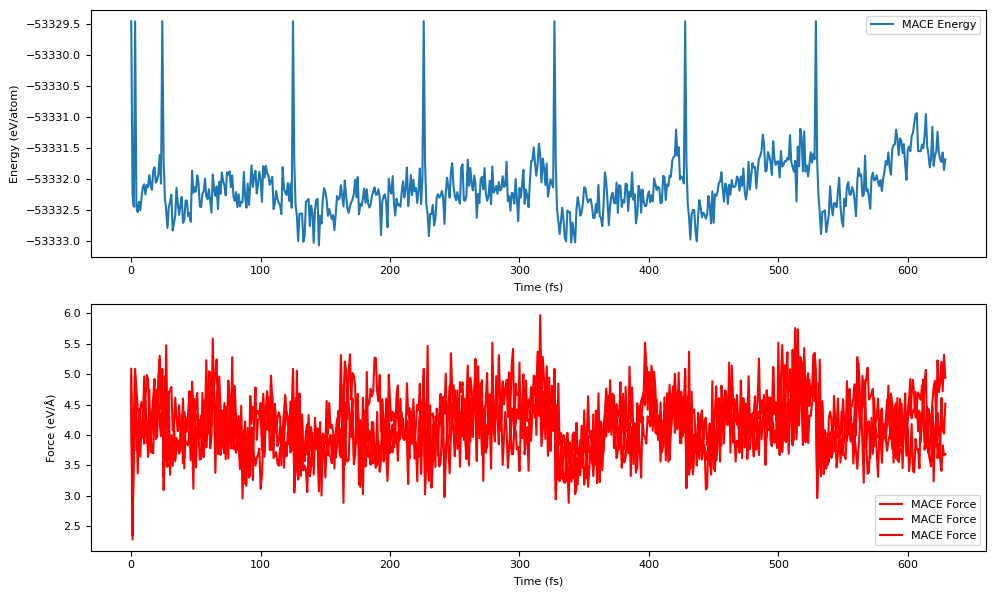

      Step     Time          Energy          fmax
BFGS:    0 17:18:22   -53331.684087        1.791301
BFGS:    1 17:18:22   -53332.361756        1.163898
BFGS:    2 17:18:22   -53333.298635        1.360321
BFGS:    3 17:18:22   -53333.592685        0.851722
BFGS:    4 17:18:22   -53333.924122        0.857442
BFGS:    5 17:18:22   -53334.189251        0.721516
BFGS:    6 17:18:22   -53334.410351        0.705267
BFGS:    7 17:18:23   -53334.555329        0.493613
BFGS:    8 17:18:23   -53334.695995        0.601625
BFGS:    9 17:18:23   -53334.834193        0.621745
BFGS:   10 17:18:23   -53334.943818        0.505690
BFGS:   11 17:18:23   -53335.026620        0.496586
BFGS:   12 17:18:23   -53335.094331        0.324139
BFGS:   13 17:18:23   -53335.153598        0.424862
BFGS:   14 17:18:23   -53335.208966        0.326073
BFGS:   15 17:18:23   -53335.259230        0.389350
BFGS:   16 17:18:23   -53335.307547        0.313407
BFGS:   17 17:18:23   -53335.349203        0.316527
BFGS:   18 17:

In [5]:
import numpy as np
from ase.io import read, write
from ase import units
from ase.md.langevin import Langevin
from ase.optimize import BFGS
from mace.calculators import MACECalculator
from matplotlib import pyplot as plt
from tqdm import tqdm
import os

# 1️⃣ 加载训练好的 MACE 模型
model_path = 'MACE_model.model'  # 你的模型文件路径

# 检查模型文件是否存在
if not os.path.exists(model_path):
    print(f"Model file {model_path} not found!")
else:
    calculator = MACECalculator(
        model_path=model_path,  # 你的模型文件
        device='cuda'  # 如果没有 GPU，则改成 'cpu'
    )

    # 1️⃣ 加载分子结构数据（读取第一帧）
    init_conf = read('test.extxyz', '0')  # 读取第一帧
    init_conf.set_calculator(calculator)  # 设置计算器（此处calculator为MACE）

    # 2️⃣ 设置 Langevin 动力学参数
    dyn = Langevin(
        init_conf,                # 初始分子结构
        2.0 * units.fs,           # 时间步长
        temperature_K=310,        # 目标温度 310K
        friction=5e-3             # 摩擦系数
    )

    # 3️⃣ 记录每 10 步的数据，并附加计算结果（如能量，力等）
    def write_frame():
        # 获取力
        forces = dyn.atoms.get_forces()

        # 获取势能和温度
        energy = dyn.atoms.get_potential_energy()
        temperature = dyn.atoms.get_temperature()

        # 将能量、力、温度等附加到原子信息中（使用不同的键名避免重复）
        dyn.atoms.info['energy_langevin'] = energy
        dyn.atoms.arrays['forces_langevin'] = forces
        dyn.atoms.info['temperature'] = temperature

        # 保存到文件
        dyn.atoms.write('test.xyz', append=True)  # 追加方式写入数据

        # 输出相关信息
        print(f"Time: {dyn.get_time() / units.fs:.2f} fs, Energy: {energy:.3f} eV, Temperature: {temperature:.2f} K")

    # 4️⃣ 将 write_frame 函数附加到 MD 动力学模拟中，每 10 步记录一次
    dyn.attach(write_frame, interval=10)  # 每 10 步存一次数据

    # 5️⃣ 运行 1000 个时间步（你可以根据需求调整步数）
    print("Running Molecular Dynamics Simulation...")
    dyn.run(1000)  # 运行 1000 步

    print("Simulation completed. Results saved in test.xyz.")

    # 6️⃣ 进行 MACE 力的预测
    
    mace_calcs = MACECalculator(model_path=model_path, device='cuda')

    # 7️⃣ 进行 MACE 力的预测
    # 读取模拟过程中保存的轨迹
    traj = read('test.xyz', ':')

    forces_mace = []
    energies_mace = []

    for at in tqdm(traj):
        at.calc = mace_calcs  # 使用 MACE 计算器
        forces = at.get_forces()  # 获取预测的力
        energies_mace.append(at.get_potential_energy())  # 获取势能

        # 保存力到原子数组中（使用不同的键名避免重复）
        at.arrays['forces_mace'] = forces
        at.info['energy_mace'] = at.get_potential_energy()  # 保存MACE能量

        forces_mace.append(forces)

    # 8️⃣ 绘制能量和力随时间变化的图
    # 绘制 MACE 力和势能随时间的变化
    plt.figure(figsize=(10, 6))

    # 绘制能量随时间的变化
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(traj)), energies_mace, label='MACE Energy')
    plt.xlabel('Time (fs)')
    plt.ylabel('Energy (eV/atom)')
    plt.legend()

    # 绘制力随时间的变化
    plt.subplot(2, 1, 2)
    force_magnitude = np.linalg.norm(np.array(forces_mace), axis=1)
    plt.plot(np.arange(len(traj)), force_magnitude, label='MACE Force', color='r')
    plt.xlabel('Time (fs)')
    plt.ylabel('Force (eV/Å)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 9️⃣ 进行结构优化：使用 BFGS 优化器进行结构优化，直到力趋近于零
    # 使用 BFGS 优化器进行结构优化
    opt = BFGS(traj[-1])  # 使用最后一帧（或选择其他帧进行优化）
    opt.run(fmax=0.01)  # 设置最大力为 0.01 eV/Å

    # 10️⃣ 保存优化后的结果
    write('test_optimized.xyz', traj[-1])  # 保存优化后的轨迹文件

    print("Optimization completed. Optimized structure saved in test_optimized.xyz.")
